In [17]:
# Imports
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from geopy.geocoders import Nominatim
from geopandas.tools import geocode
from geopy.extra.rate_limiter import RateLimiter
from shapely.ops import unary_union
%matplotlib inline

In [18]:
fp_grid = r'data/YKR/MetropAccess_YKR_grid_EurefFIN.shp'

grid = gpd.read_file(fp_grid)

In [3]:
grid.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [28]:
orig_address_input = 'Radiokuja 6, 00240, Helsinki, Finland'
dest_address_input = 'Väinö Auerin katu 13, 00560, Helsinki, Finland'

#orig_address_input = str(input('Lähtöosoite')+', Helsinki, Finland')
#dest_address_input = str(input('Päämääräosoite')+', Helsinki, Finland')

origin_point = geocode(orig_address_input, provider='nominatim', user_agent='autogis_EH', timeout=4)
dest_point = geocode(dest_address_input, provider='nominatim', user_agent='autogis_EH', timeout=4)

origin_point = origin_point.to_crs(epsg=3067)
dest_point = dest_point.to_crs(epsg=3067)

In [16]:
grid.head(1)

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."


<AxesSubplot:>

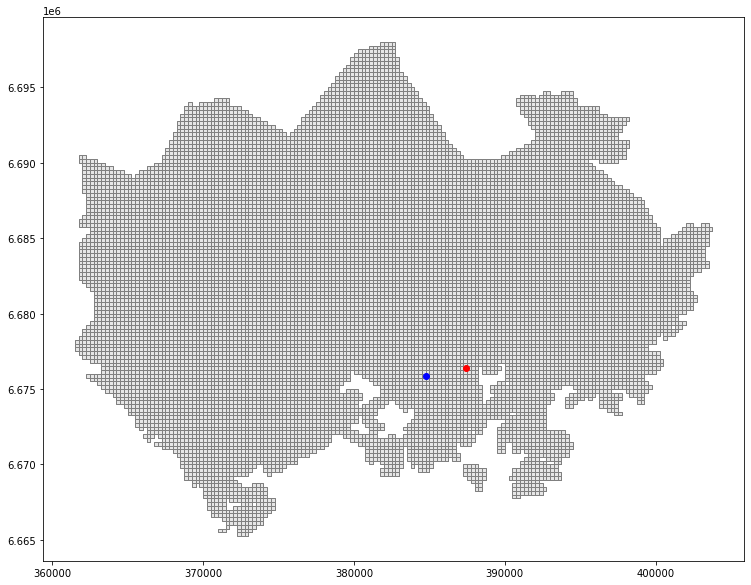

In [29]:
fig, ax = plt.subplots(figsize=(14,10))

grid.plot(ax=ax, facecolor=[0.9,0.9,0.9], edgecolor=[0.5,0.5,0.5])
origin_point.plot(ax=ax, color=[0,0,1])
dest_point.plot(ax=ax, color=[1,0,0])